In [1]:
%matplotlib inline
from collections import defaultdict
import pymc as pm
from pymc.Matplot import plot as mcplot
import numpy as np
from matplotlib import pyplot as plt
import json
from pymongo import MongoClient
import pymongo
from bson.objectid import ObjectId
import copy

In [41]:
client = MongoClient()
db = client.heroku_rnwkcq9r

def question_text(question_id):
    question = db.question.find_one({'_id': question_id})
    return question['text']

def question_max_value(question_id):
    question = db.question.find_one({'_id': question_id})
    if question['question_type'] == "boolean":
        return 1
    elif question["question_type"] == "numerical":
        if 'numericalAnswers' in question:
            max_value = max(map(int,question['numericalAnswers'].keys()))
            return max_value
        else:
            return 5

def answer_value(answer_id):
    answer = db.answer.find_one({'_id': answer_id})
    q_id = answer['question']
    if 'numerical_answer' in answer:
        return answer['numerical_answer'] / float(question_max_value(q_id))
    elif 'boolean_answer' in answer:
        return answer['boolean_answer'] / float(question_max_value(q_id))

def answer_with_score(answer_id):
    answer = db.answer.find_one({'_id': answer_id})
    return 'text_answer' not in answer

def score_handin_grader(handin_id,grader_id):
    # find all answers to the hand in of the grader and average it out
    report_grade = db.report_grade.find_one({'handin': handin_id, 'giver': grader_id})
    answers = db.answer.find({'report_grade': report_grade['_id'] })
    n_asnweres = 0
    handin_acc = 0.0
    for answer in answers:
        if answer_with_score(answer['_id']):
            handin_acc = handin_acc + answer_value(answer['_id'])
            n_asnweres = n_asnweres + 1
    return handin_acc / float(n_asnweres)

def score_handin_list(handin_id):
    scores = list()
    report_grades = db.report_grade.find({'handin': handin_id, 'state': 'ANSWERED'})
    for report_grade in report_grades:
        scores.append((score_handin_grader(handin_id,report_grade['giver']),report_grade['giver']))
    return scores

# finds the reported score for each handins in an assignment
# returns a list containing the score of each handin
def assignment_handins(assignment_id):
    handins_reports = list()
    handins = db.handin.find({'assignment': assignment_id})
    for handin in handins:
        handins_reports.append((score_handin_list(handin['_id']),handin['_id']))
    return handins_reports

# finds the reported score for each handins in an assignment
# returns a list containing the score of each handin
def assignment_handins_id(assignment_id):
    handins_reports = list()
    handins = db.handin.find({'assignment': assignment_id})
    for handin in handins:
        handins_reports.append(handin['_id'])
    return handins_reports

In [3]:
def handin_model(data):
    N_H = len(data)
    
    # Bias
    T = dict()
    B = dict()
    B_mu = dict()
    B_tau = dict()
    O = list()

    for h in range(0, N_H):
        (scores,h_id) = data[h]
        N_G = len(scores)
        
        T_mu = pm.Normal('T_mu_%s' % str(h_id),0.5,25)
        T_tau = pm.Gamma('T_tau_%s' % str(h_id),10,0.1)
        T[h_id] = pm.Normal('T_%s' % str(h_id), mu=T_mu, tau=T_tau)
        
        for g in range(0, N_G):
            (val,g_id) = scores[g]

            if g_id not in B:
                if g_id not in B_mu:
                    B_mu[g_id] = pm.Normal('B_mu_%s' % str(g_id),0,100)
                if g_id not in B_tau:
                    B_tau[g_id] = pm.Gamma('B_tau_%s' % str(g_id), 50, 0.1)
                B[g_id] = pm.Normal('B_%s' % str(g_id), mu=B_mu[g_id], tau=B_tau[g_id])
            O.append(pm.Normal('O_%(h)s_%(g)s' % {'h': h, 'g':g}, mu = T[h_id] + B[g_id], tau=100, observed=True, value=val))
        
            
    collection = [pm.Container(T),
                  pm.Container(O),
                  pm.Container(B)]
    
    model = pm.Model(collection)
    map_ = pm.MAP(model)
    map_.fit()
    return model

In [4]:
def execute_model(model,samples):
    mcmc = pm.MCMC(model)
    mcmc.sample(samples)
    return mcmc

In [5]:
def run_3_iteration(model_,values,samples):
    model_back = model_(values)
    mcmc_back_1 = execute_model(model_back,samples)
    mcmc_back_2 = execute_model(model_back,samples)
    mcmc_back_3 = execute_model(model_back,samples)
    return [mcmc_back_1,mcmc_back_2,mcmc_back_3]

In [8]:
data_assignment = assignment_handins(ObjectId("55f277cff3bd61000a2112d4"))

In [9]:
mcmc = run_3_iteration(handin_model,data_assignment,1500)

 [-----------------100%-----------------] 1500 of 1500 complete in 94.0 sec

In [10]:
def grader_ids(assignment_id):
    graders = set()
    report_grades = db.report_grade.find({'assignment':assignment_id})
    for report_grade in report_grades:
        graders.add(report_grade['giver'])
    return list(graders)

In [11]:
def grader_ids_course(course_id):
    graders = set()
    course = db.course.find_one({'_id':course_id})
    return course['students']

In [12]:
def grader_id(grader_name):
    grader = db.user.find_one({'name': grader_name})
    return grader['_id']

In [13]:
def grader_name(grader_id):
    grader = db.user.find_one({'_id': grader_id})
    return grader['name']

In [14]:
def find_bias(assignment_id,mcmc,f):
    bias_abs = list()
    for g in grader_ids(assignment_id):
        try:     
            bias_mean = f(mcmc.trace('B_%s' % str(g))[:])
            name = str(g)
            bias_abs.append((bias_mean,name))
        except:
#            print "error for grader: %s" % grader_name(g)
            pass
    return bias_abs

In [15]:
def find_T(assignment_id,mcmc,f):
    bias = list()
    for h in assignment_handins_id(assignment_id):
        try:     
            bias_mean = f(mcmc.trace('T_%s' % str(h))[:])
            name = str(h)
            bias.append((bias_mean,name))
        except:
            #print "error for grader: %s" % grader_name(g)
            pass
    return bias

In [16]:
def number_of_reports(g_id, assignment_id):
    reports = db.report_grade.find({'assignment': assignment_id, 'giver': g_id, 'state': 'ANSWERED'})
    return reports.count()

In [17]:
def number_of_reports_course(g_id, course_id):
    count = 0
    assignments = db.assignment.find({'course': course_id})
    for assignment in assignments:
        reports = db.report_grade.find({'assignment': assignment['_id'], 'giver': g_id, 'state': 'ANSWERED'})
        count = count + reports.count()
    return count

In [24]:
def plot_result(_id,data,mcmc,find,func=np.mean):
    data_1 = find(_id, mcmc[0], func)
    data_2 = find(_id, mcmc[1], func)
    data_3 = find(_id, mcmc[2], func)
    
    # Generate dict of the found values in each run for each grader
    compared = defaultdict(list)
    collected = list()
    collected = data_1[:]
    collected.extend(data_2[:])
    collected.extend(data_3[:])
    for (value, g_id) in collected:
        compared[g_id].append(value)
        
    # Produce a box plot where the graders are sorted after mean value of the found values
    ax = plt.subplot(111)

    sorted_list = compared.items()
    sorted_list.sort(key=lambda x: np.mean(x[1][:]))

    labels = list()
    if 'bias' in find.func_name:
        for (g_id, value) in sorted_list:
            name = grader_name(ObjectId(g_id))
            reported = number_of_reports_course(ObjectId(g_id), _id)
            labels.append(name + ": " + str(reported))
    else:
        for (g_id, value) in sorted_list:
            name = g_id
            labels.append(name)
        plt.xlim(0,1)
    values = map(lambda x: x[1], sorted_list)
    plt.boxplot(values,0, vert=False, labels=labels)

    box = ax.get_position()
    ax.set_position([box.x0, box.y0,
                     box.width*1.5, box.height*5])
    plt.vlines(0, 0, 120, color="k", linestyles="--", lw=1)
    plt.xlabel("Absolute mean value of the bias distributions of a grader")
    plt.show()

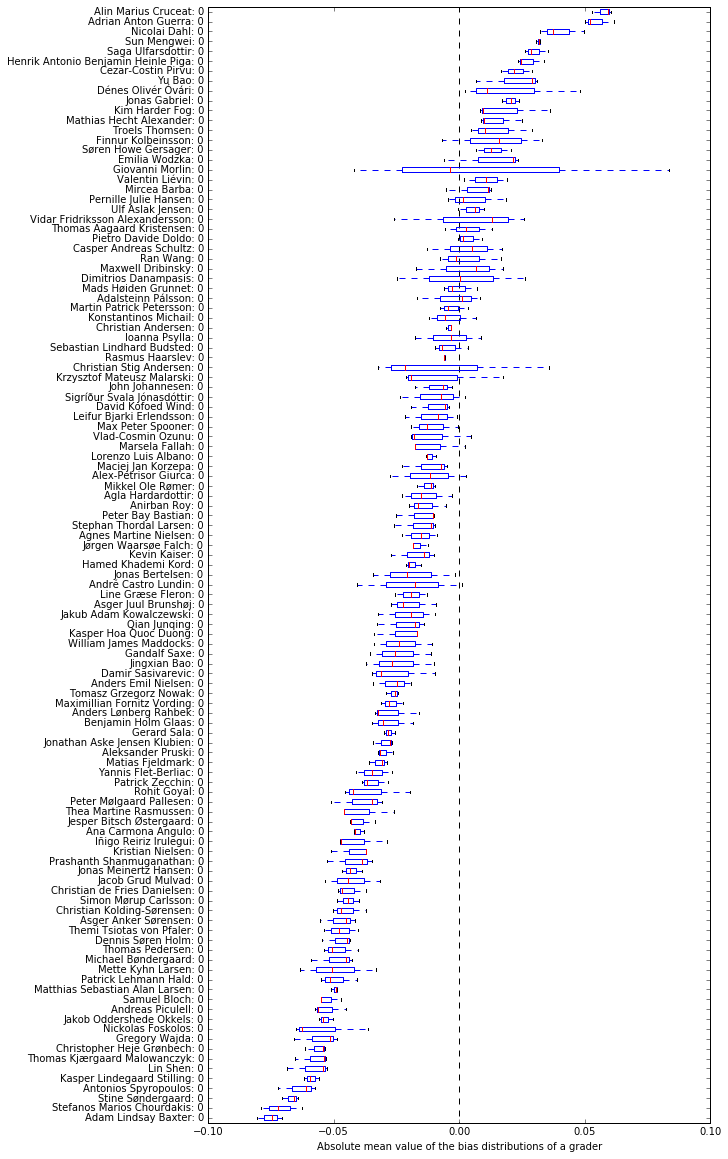

In [25]:
plot_result(ObjectId("55f277cff3bd61000a2112d4"),data_assignment,mcmc,find_bias)

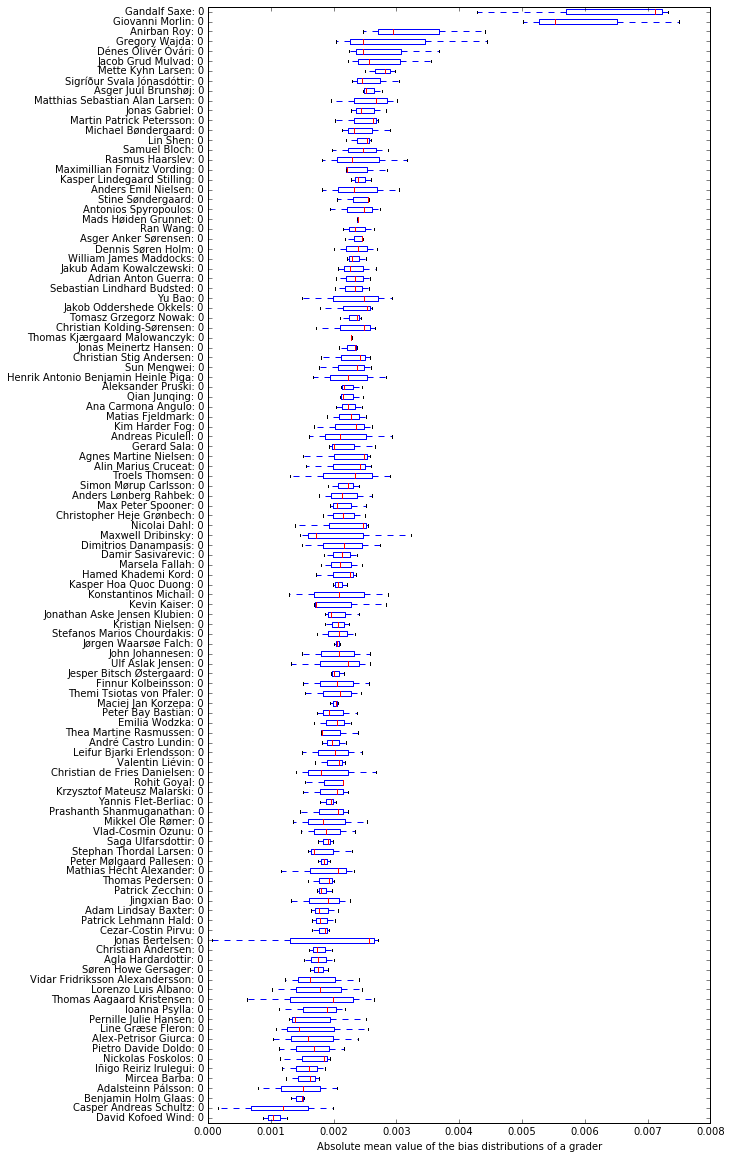

In [26]:
plot_result(ObjectId("55f277cff3bd61000a2112d4"),data_assignment,mcmc,find_bias,np.var)

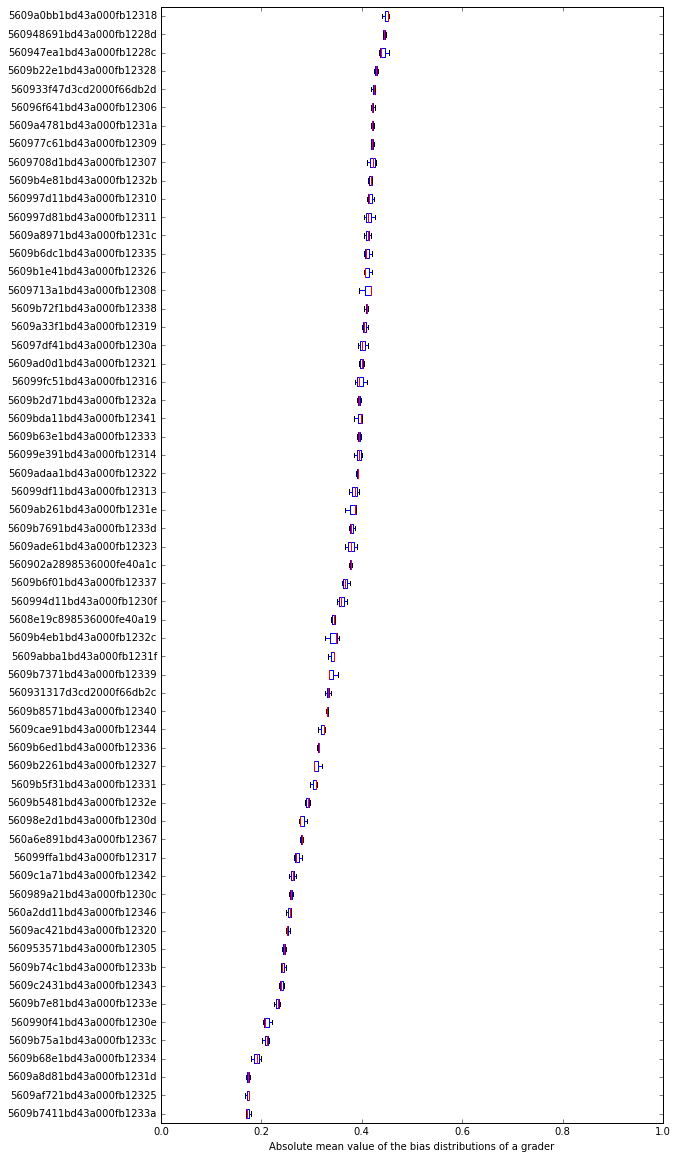

In [27]:
plot_result(ObjectId("55f277cff3bd61000a2112d4"),data_assignment,mcmc,find_T)

In [28]:
weights = list()
with open('Data/weight.txt') as f:
    for line in f:
        if len(line) != 24:
            weights.append(line[:-1])

bias_abs_c = map(lambda x: (abs(x[0]),x[1]),find_bias(ObjectId("55f277cff3bd61000a2112d4"), mcmc[0], np.mean))
bias_abs_c.sort()

compared_c = list()
for idx, (value, _id) in enumerate(bias_abs_c):
    if _id in weights:
        compared_c.append((_id ,idx, weights.index(_id)))

compared_c.sort(key=lambda x:abs(x[2]-x[1]))

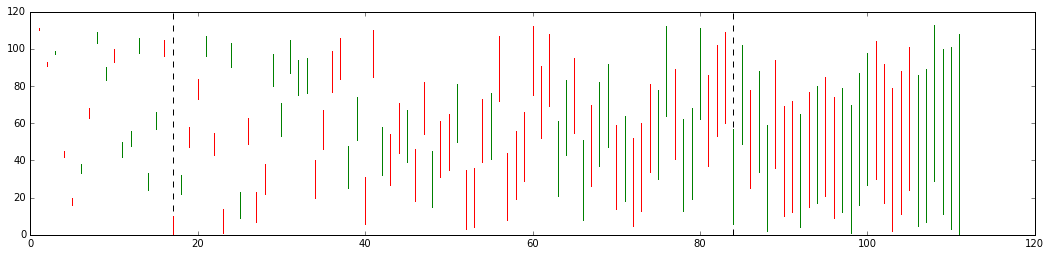

In [29]:
ax = plt.subplot(111)

dis_ten = 0
dis_fifty = 0

for idx, (_id, bias,weight) in enumerate(compared_c):
    if bias > weight:
        plt.plot([idx,idx],[bias,weight], color='r')
    else:
        plt.plot([idx,idx],[bias,weight], color='g')
    if dis_ten == 0 and abs(bias-weight) >= 10:
        dis_ten = idx
        plt.vlines(idx, 0, 120, color="k", linestyles="--", lw=1)
    if dis_fifty == 0 and abs(bias-weight) >= 50:
        dis_fifty = idx
        plt.vlines(idx, 0, 120, color="k", linestyles="--", lw=1)

box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width * 3, box.height])
    
plt.show()

### Full Data

In [30]:
def course_handins(course_id):
    handins = list()
    assignments = db.assignment.find({'course':course_id})
    for assignment in assignments:
        handins.extend(assignment_handins(assignment['_id']))
    return handins

In [31]:
# finds the reported score for each handins in an assignment
# returns a list containing the score of each handin
def course_handins_id(course_id):
    handins_reports = list()
    assignments = db.assignment.find({'course': course_id})
    for assignment in assignments:
        handins = db.handin.find({'assignment': assignment['_id']})
        for handin in handins:
            handins_reports.append(handin['_id'])
    return handins_reports

In [ ]:
data_course = course_handins(ObjectId("55d9cb9ea6fb8f00080da4a1"))

In [ ]:
mcmc_c = run_3_iteration(handin_model,data_course,1500)

In [ ]:
def find_bias_course(course_id,mcmc,f):
    bias_abs = list()
    for g in grader_ids_course(course_id):
        try:     
            bias_mean = f(mcmc.trace('B_%s' % str(g))[:])
            name = str(g)
            bias_abs.append((bias_mean,name))
        except:
            #print "error for grader: %s" % grader_name(g)
            pass
    return bias_abs

In [ ]:
def find_T_course(course_id,mcmc,f):
    true_l = list()
    for h in course_handins_id(course_id):
        try:
            handin = f(mcmc.trace('T_%s' % str(h))[:])
            name = str(h)
            true_l.append((handin,name))
        except:
            #print "error for grader: %s" % grader_name(g)
            pass
    return true_l

In [ ]:
plot_result(ObjectId("55d9cb9ea6fb8f00080da4a1"),data_course,mcmc_c,find_bias_course)

In [ ]:
plot_result(ObjectId("55d9cb9ea6fb8f00080da4a1"),data_course,mcmc_c,find_bias_course,np.var)

In [ ]:
plot_result(ObjectId("55d9cb9ea6fb8f00080da4a1"),data_course,mcmc_c,find_T_course)

In [39]:
weights = list()
with open('Data/weight.txt') as f:
    for line in f:
        if len(line) != 24:
            weights.append(line[:-1])

bias_abs_c = map(lambda x: (abs(x[0]),x[1]),find_bias_course(ObjectId("55d9cb9ea6fb8f00080da4a1"), mcmc_c[0], np.mean))
bias_abs_c.sort()

compared_c = list()
for idx, (value, _id) in enumerate(bias_abs_c):
    if _id in weights:
        compared_c.append((_id ,idx, weights.index(_id)))

compared_c.sort(key=lambda x:abs(x[2]-x[1]))

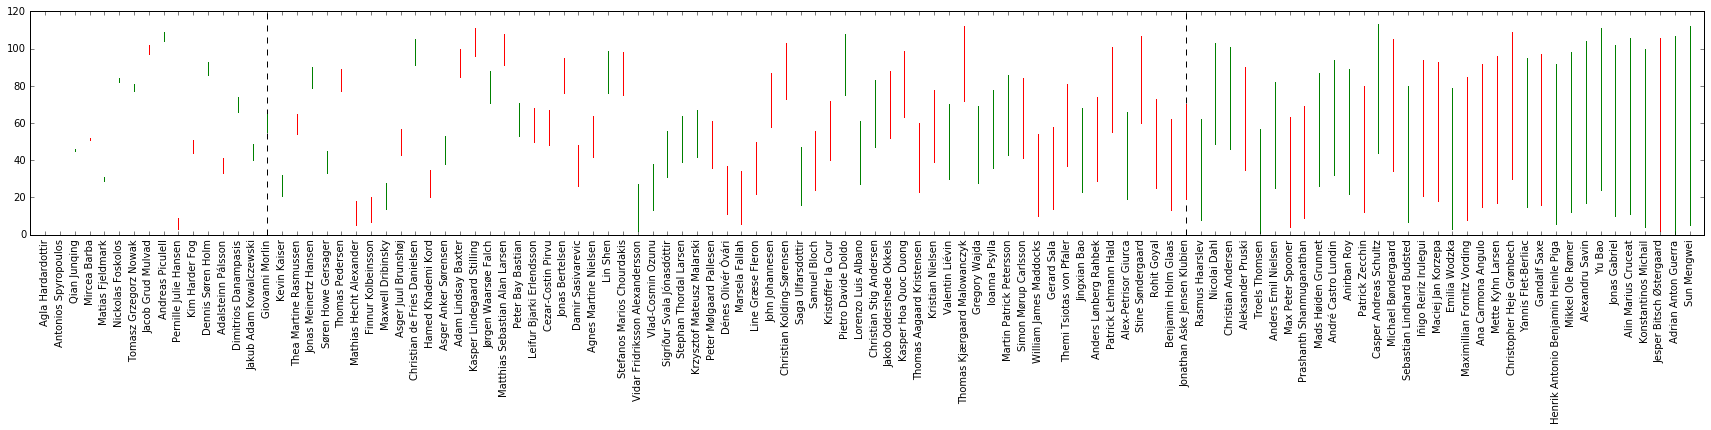

In [40]:
ax = plt.subplot(111)

dis_ten = 0
dis_fifty = 0

labels = list()

for idx, (_id, bias,weight) in enumerate(compared_c):
    labels.append(grader_name(ObjectId(_id)))
    if bias > weight:
        plt.plot([idx,idx],[bias,weight], color='r')
    else:
        plt.plot([idx,idx],[bias,weight], color='g')
    if dis_ten == 0 and abs(bias-weight) >= 10:
        dis_ten = idx
        plt.vlines(idx, 0, 120, color="k", linestyles="--", lw=1)
    if dis_fifty == 0 and abs(bias-weight) >= 50:
        dis_fifty = idx
        plt.vlines(idx, 0, 120, color="k", linestyles="--", lw=1)

plt.xticks(range(0,len(compared_c)), labels, rotation=90)
box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width * 5, box.height])
plt.xlim(-1,len(compared_c))
plt.show()